In [1]:
%%capture

%pip install "tensorflow==2.15.*"
%pip install "tensorflow-text==2.15.*"
%pip install "tf-models-official==2.15.*"
%pip install "tf-keras==2.15.*"

In [2]:
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [3]:
# Load datasets

dataset_name = 'ccc-bert-250318'

autotune = tf.data.AUTOTUNE
batch_size = 32
seed = 42

ds_dir = os.path.join('/kaggle/input', dataset_name)

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

def oneHotLabels(x, y): return x, tf.one_hot(y, depth=len(raw_train_ds.class_names))

train_ds = raw_train_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = raw_val_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'test'),
    batch_size=batch_size)

test_ds = raw_test_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

Found 649 files belonging to 4 classes.
Using 520 files for training.
Found 649 files belonging to 4 classes.
Using 129 files for validation.
Found 164 files belonging to 4 classes.


In [4]:
# Build BERT neural net

tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)

In [5]:
# Set up model training parameters

epochs = 20
init_lr = 3e-5

loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=3, # Number of epochs with no improvement before stopping
    mode='max',  # We want to maximize accuracy
    verbose=1,
    restore_best_weights=True, # Restore the best weights once training stops
    min_delta=0.001)  # Minimum change to qualify as an improvement

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

In [6]:
# Train model

# instantiating the model in the strategy scope creates the model on the TPU

classifier_model = tf.keras.Model(text_input, net)
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

training_history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/20
17/17 [==============================] - 33s 983ms/step - loss: 1.5307 - categorical_accuracy: 0.3212 - val_loss: 1.4012 - val_categorical_accuracy: 0.3566
Epoch 2/20
17/17 [==============================] - 15s 906ms/step - loss: 1.2875 - categorical_accuracy: 0.4346 - val_loss: 1.1771 - val_categorical_accuracy: 0.4574
Epoch 3/20
17/17 [==============================] - 16s 924ms/step - loss: 0.9928 - categorical_accuracy: 0.5615 - val_loss: 1.0829 - val_categorical_accuracy: 0.5116
Epoch 4/20
17/17 [==============================] - 16s 954ms/step - loss: 0.7323 - categorical_accuracy: 0.7269 - val_loss: 0.9858 - val_categorical_accuracy: 0.5426
Epoch 5/20
17/17 [==============================] - 17s 982ms/step - loss: 0.5210 - categorical_accuracy: 0.8000 - val_loss: 1.0389 - val_categorical_accuracy: 0.5504
Epoch 6/20
17/17 [==============================] - 17s 1s/step - loss: 0.4424 - categorical_accuracy: 0.8250 - val_loss: 1.1829 - val_categorical_accuracy: 0.5504
E

In [7]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

6/6 [==============================] - 2s 295ms/step - loss: 0.8586 - categorical_accuracy: 0.6707
Loss: 0.8586220145225525
Accuracy: 0.6707317233085632


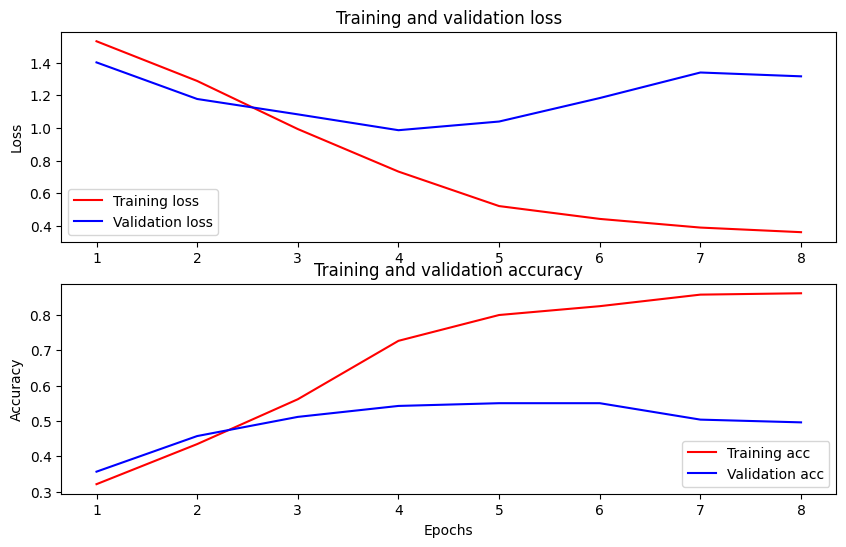

In [8]:
history_dict = training_history.history

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Export model for inference

saved_model_path = '/kaggle/working/{}_model'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)

saved_model_path = '/kaggle/output/{}_model'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)